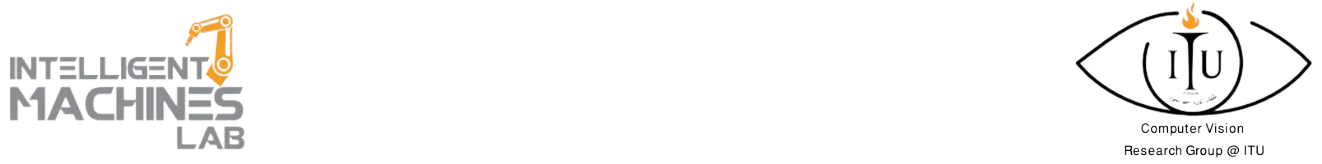

## Generative AI & LLM Fall 2024
## Assignment 2: Implementing a VAE using CNN and pytorch

In this assignment, you will implement a VAE using CNN and pytorch. You will use the MNIST dataset for this assignment.

**You will need to implement the following:**

1. The VAE Model
2. Kaiming Initialization also known as He Initialization (https://paperswithcode.com/method/he-initialization)
3. The VAE loss function
4. The forward pass
5. The training loop
6. The evaluation loop
7. The sampling loop
8. Visualize the latent space


**Guidelines:**

1. Use this notebook as a template to implement the VAE model.
2. Try your best to avoid using ChatGPT or any other LLM to complete this assignment.
3. If you get stuck, please reach out at `manzoor.rohan97@gmail.com`
4. Ensure proper formatting of the code.
5. While you will be implementing the assignment on Colab, you are also required to upload the project to github and share the link with us.


**The assignment will be evaluated based on the following criteria:**

| Criteria                | Marks |
|-------------------------|-------|
| 1. VAE model            | 2.5   |
| 2. Training Loop        | 2.5   |
| 3. Correct Sampling     | 2.0   |
| 4. Viva                 | 3.0   |
| Total                   | 10.0  |


Name: Adeen Zainub

Reg No: MSDS23044

Github Link: `your github link here`

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init


from torchvision import datasets, transforms
import torch.optim as optim

# Model Definition

In [17]:
def weights_init(m):
    # TODO: Use He Initialization and use this function to initialize the weights of the model
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    #pass

class CNN_VAE(nn.Module):
    def __init__(self, input_channels=1, h_dims=[32, 64], latent_dims=2):
        """
        Initializes the CNN_VAE model.

        Args:
            input_channels (int): Number of input channels (e.g., 1 for grayscale images).
            h_dims (list): A list defining the number of output channels for each convolutional layer in the encoder.
            latent_dims (int): Dimensionality of the latent space.
        """
        super(CNN_VAE, self).__init__()
                # TODO: Initialize the encoder Layers
        # You encoder will have 2 convolutional layers, a fixed kernel size of 3, stride of 2, padding of 1
        # The output of the encoder will be flattened to a single vector


        # TODO: Initialize the FC layers to output the mean and log variance


        # TODO: Initialize the decoder layers
        # The decoder will have 2 transposed convolutional layers, a fixed kernel size of 3, stride of 2, padding of 1
        # The output of the decoder will be a tensor of the same size as the input


        # TODO: Apply weight initialization using the weights_init function

        self.h_dims = h_dims
        # initializing the encoder
        self.conv1 = nn.Conv2d(input_channels, h_dims[0], kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(h_dims[0], h_dims[1], kernel_size=3, stride=2, padding=1)
       # Fc layer  mean and log variance
        self.fc_mu = nn.Linear(h_dims[1] * 7 * 7, latent_dims)
        self.fc_logvar = nn.Linear(h_dims[1] * 7 * 7, latent_dims)

        # initialize the decoder
        self.fc_dec = nn.Linear(latent_dims, h_dims[1] * 7 * 7)
        #transpose2d used for upsampling
        self.deconv1 = nn.ConvTranspose2d(h_dims[1], h_dims[0], kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(h_dims[0], input_channels, kernel_size=3, stride=2, padding=1, output_padding=1)

        # Apply weight initialization
        self.apply(weights_init)

    def reparametrize(self, mu, logvar):
        """
        Reparameterization trick to sample from the latent space.

        Args:
            mu (torch.Tensor): Mean of the latent distribution.
            logvar (torch.Tensor): Log variance of the latent distribution.

        Returns:
            torch.Tensor: Sampled latent variable from the distribution defined by mu and logvar.
        """
        # TODO: Implement the reparametrization trick. Notice the input argument is logvar and not sigma. Can you guess why?

        #Reason :
        # we don't get negative values for the variance
        # predicting very large variances directly can be hard, but predicting the log of those large variances keeps the numbers manageable.
        # improves the gradient flow during backpropagation. When working with logs, the gradients are more stable and don't explode or vanish as easily

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        # latent variable z is formed adding the random noise scaled by the standard deviation to the mean
        # z=μ+ϵ×σ
        return mu + eps * std

    def encode(self, x):
        """
        Encodes the input data into the latent space representation.

        Args:
            x (torch.Tensor): Input data (e.g., images) to be encoded.

        Returns:
            tuple: A tuple containing:
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        # TODO: Implement the encoding process
        x = F.leaky_relu(self.conv1(x))  # Use lowercase leaky_relu from functional API
        x = F.leaky_relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the output
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        """
        Decodes the latent representation back to the original data space.

        Args:
            z (torch.Tensor): Latent representation to be decoded.

        Returns:
            torch.Tensor: Reconstructed data from the latent representation.
        """
        # TODO: Implement the decoding process
        x = F.leaky_relu(self.fc_dec(z))
        x = x.view(x.size(0), self.h_dims[1], 7, 7)  # Reshape for the convolution layers
        x = F.leaky_relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x)) #used to keep the values in range of 0-1 because easyto compute for loss that is binary cross entropy loss
        return x

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input data (e.g., images) for reconstruction.

        Returns:
            tuple: A tuple containing:
                - x_reconstructed (torch.Tensor): Reconstructed input data.
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        #firstly latent space is encoded
        #that latent space is reparameterized
        #then we decode the reparameterized latent space
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x_reparameterized = self.decode(z)
        return x_reparameterized, mu, logvar # Return the reconstructed output, mu, and logvar

# Usage
INPUT_CHANNELS = 1
INPUT_SIZE = 28
model = CNN_VAE(input_channels=INPUT_CHANNELS)
output, mu, logvar = model.forward(torch.randn((1, INPUT_CHANNELS, INPUT_SIZE, INPUT_SIZE)))
print(output.shape)

print("Mu shape:", mu.shape)           # Should be [1, latent_dims]
print("Logvar shape:", logvar.shape)

torch.Size([1, 1, 28, 28])
Mu shape: torch.Size([1, 2])
Logvar shape: torch.Size([1, 2])


# Dataset Loading

In [18]:
# Hyper-parameters
# you can change these to see how the model performs
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
INPUT_DIMS = 1
HID_DIMS = [32, 64]
Z_DIMS = 20
NUM_EPOCHS = 2
LR = 3e-4
BATCH_SIZE = 64
VAL_AFTER = 800

In [19]:
# Loading dataset
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# TODO: Load the MNIST dataset and prepare the dataloaders.
# You can use the torchvision.datasets.MNIST and torch.utils.data.DataLoader to load the dataset.
# You will need separate daataloader for train and test set

# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.ToTensor(),  #images to tensors

])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

print("Training set size:" ,len(train_dataset))
print("Test set size: ",len(test_dataset))
print("batches in Train DataLoader :" ,len(train_loader))
print("batches in test DataLoader :", len(test_loader))


Training set size: 60000
Test set size:  10000
batches in Train DataLoader : 938
batches in test DataLoader : 157


In [20]:
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

def plot_image(img, nrow=12):
    plt.figure(figsize=(10, 6))
    plt.imshow(make_grid(img, nrow=nrow).permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

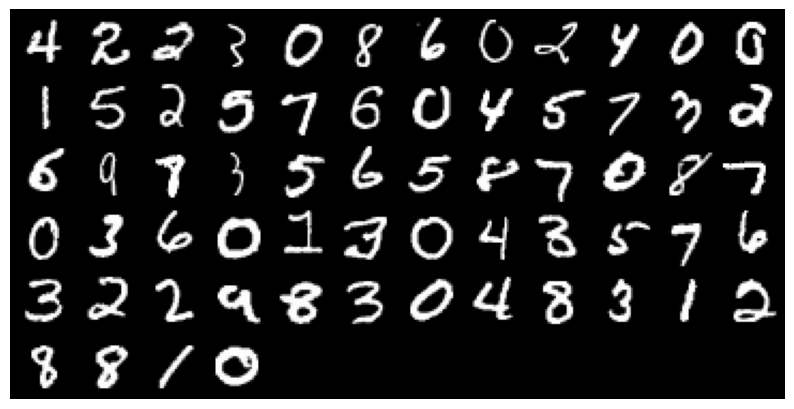

In [21]:
# TODO: Use the plot_image function to plot the images
# Load a batch of images from the train_loader
data_iter = iter(train_loader)  # iterator for the DataLoader
images, labels = next(data_iter)  # batch of images and labels

#plotting
plot_image(images, nrow=12)


# Training Loop

In [22]:
# Define VAE loss
import torch.nn.functional as F

def vae_loss(reconstructed_x, x, mu, logvar):
    # Binary Cross Entropy measures how well the VAE reconstructs the input data
    BCE = F.binary_cross_entropy(reconstructed_x.view(-1, 28 * 28), x.view(-1, 28 * 28), reduction='sum')

    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    return BCE + KLD



In [23]:
import torch
import torch.optim as optim
from tqdm import tqdm
# Instructions:
# 1. Initialize the model and the optimizer. You will be using Adam optimizer
# 2. Implement a training loop that iterates over the training data, performs forward and backward passes, and updates the model parameters.
# 3. Implement a validation loop that evaluates the model on the validation data.
# 4. Implement a progress bar to visualize the training progress.
# 5. Store your training and validation losses in train_losses and eval_losses respectively.

NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
BATCH_SIZE = 64


model = CNN_VAE(INPUT_DIMS, HID_DIMS, Z_DIMS).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


train_losses = []
eval_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0

    #  progress bar
    pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}', unit='batch')
    for x, _ in pbar:
        x = x.float().to(DEVICE)  # Move data to the specified device

        optimizer.zero_grad()  # initializing the Zero to the gradients

        # Forward pass
        reconstructed_x, mu, logvar = model(x)

        # VAE loss
        loss = vae_loss(reconstructed_x, x, mu, logvar)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pbar.set_postfix(loss=train_loss / (pbar.n + 1))  # Update progress bar with current loss

    train_losses.append(train_loss / len(train_loader))  # Average  loss for the epoch


    model.eval()  # Set the model to evaluation mode
    eval_loss = 0.0
    # test Loop
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.float().to(DEVICE)  # Move data to the specified device

            # Forward pass
            reconstructed_x, mu, logvar = model(x)  # Forward pass through the model

            # Compute the VAE loss
            loss = vae_loss(reconstructed_x, x, mu, logvar)
            eval_loss += loss.item()

    eval_losses.append(eval_loss / len(test_loader))  # Average validation loss for the epoch
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {train_losses[-1]:.4f}, Eval Loss: {eval_losses[-1]:.4f}')


Epoch 1/10: 100%|██████████| 938/938 [00:57<00:00, 16.34batch/s, loss=9.89e+3]


Epoch 1/10, Train Loss: 9888.5371, Eval Loss: 7688.9950


Epoch 2/10: 100%|██████████| 938/938 [00:57<00:00, 16.19batch/s, loss=7.5e+3]


Epoch 2/10, Train Loss: 7487.5917, Eval Loss: 7180.2554


Epoch 3/10: 100%|██████████| 938/938 [00:58<00:00, 15.92batch/s, loss=7.16e+3]


Epoch 3/10, Train Loss: 7148.2725, Eval Loss: 6969.3789


Epoch 4/10: 100%|██████████| 938/938 [00:56<00:00, 16.58batch/s, loss=6.99e+3]


Epoch 4/10, Train Loss: 6984.5678, Eval Loss: 6860.4215


Epoch 5/10: 100%|██████████| 938/938 [00:58<00:00, 16.03batch/s, loss=6.89e+3]


Epoch 5/10, Train Loss: 6887.4971, Eval Loss: 6772.2473


Epoch 6/10: 100%|██████████| 938/938 [00:57<00:00, 16.25batch/s, loss=6.83e+3]


Epoch 6/10, Train Loss: 6818.5460, Eval Loss: 6729.0265


Epoch 7/10: 100%|██████████| 938/938 [00:56<00:00, 16.71batch/s, loss=6.77e+3]


Epoch 7/10, Train Loss: 6766.6818, Eval Loss: 6681.3629


Epoch 8/10: 100%|██████████| 938/938 [00:55<00:00, 16.75batch/s, loss=6.73e+3]


Epoch 8/10, Train Loss: 6723.1392, Eval Loss: 6646.2802


Epoch 9/10: 100%|██████████| 938/938 [00:56<00:00, 16.50batch/s, loss=6.69e+3]


Epoch 9/10, Train Loss: 6686.7090, Eval Loss: 6626.2263


Epoch 10/10: 100%|██████████| 938/938 [00:56<00:00, 16.69batch/s, loss=6.66e+3]


Epoch 10/10, Train Loss: 6653.6627, Eval Loss: 6589.6347


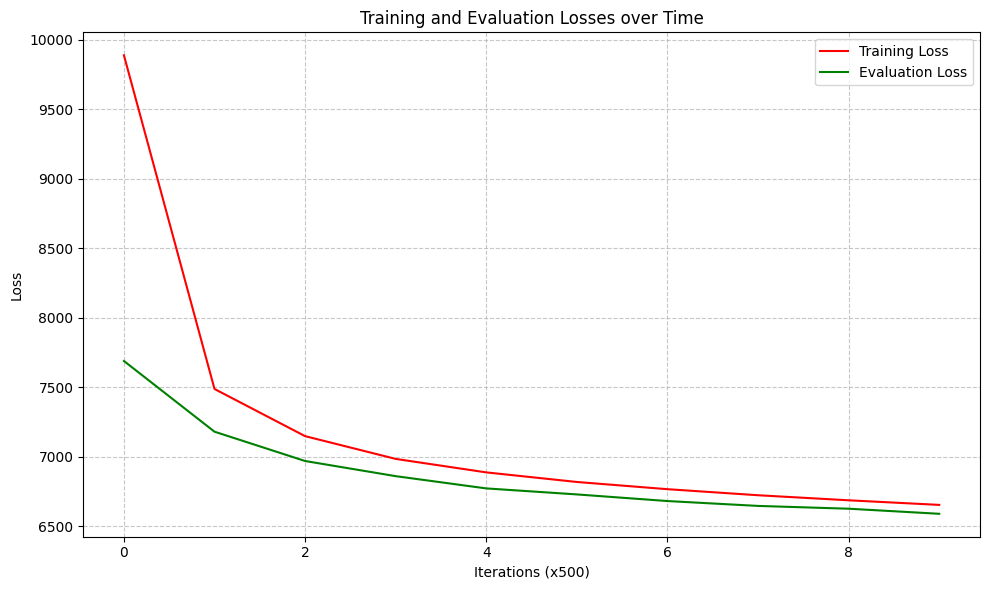

In [26]:
# Visualize your losses as your training progresses

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='red')
plt.plot(eval_losses, label='Evaluation Loss', color='green')
plt.title('Training and Evaluation Losses over Time')
plt.xlabel('Iterations (x500)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Visualizations

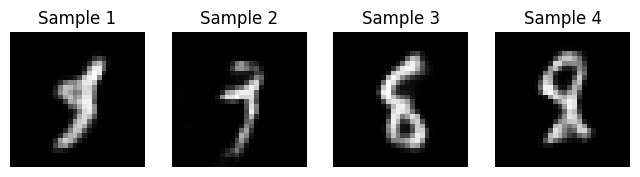

In [32]:
def generate_samples(model, digit, num_examples):

    # TODO: Implement the visualize_generations function
    # You will first encode the digit images into their latent space encodings
    # Then you will sample from the latent space and decode the samples to get the reconstructed images
    # You will then plot the reconstructed images
    # Use the plot_image function to plot the images
    model.eval()  # Set the model to evaluation mode
    z = torch.randn(num_examples, model.fc_mu.out_features)

    # latent vectors into images are decoded here
    with torch.no_grad():
        generated_images = model.decode(z)

    # Plot
    fig, axs = plt.subplots(1, num_examples, figsize=(num_examples * 2, 2))
    for i in range(num_examples):
        axs[i].imshow(generated_images[i, 0].cpu(), cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f"Sample {i+1}")

    plt.show()


digit = 9
num_examples = 4

generate_samples(model, digit, num_examples)

In [31]:
import numpy as np
def visualize_latens(dataloader, model):
    # TODO: Implement the visualize_latens function
    # Set your model's latent space to 2 and train the model
    # Encode all samples from MNIST test loader to the latent space
    # Plot them using scatter plot to show how your model has been able differentiate between them
        model.eval()  # Set the model to evaluation mode

        all_latents = []
        all_labels = []

        # Iterate over the test dataset and encode the images to their latent space
        with torch.no_grad():
            for batch in dataloader:
                imgs, labels = batch
                imgs = imgs.to(next(model.parameters()).device)  # Move images to the same device as the model

                # Encode the images to latent space
                mu, _ = model.encode(imgs)  # Get the mean of the latent distribution
                all_latents.append(mu.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        # Combined all latent vectors and labels
        all_latents = np.concatenate(all_latents, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        # Plot the latent space
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(all_latents[:, 0], all_latents[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, ticks=range(10))
        plt.title('Latent Space Visualization')
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.show()



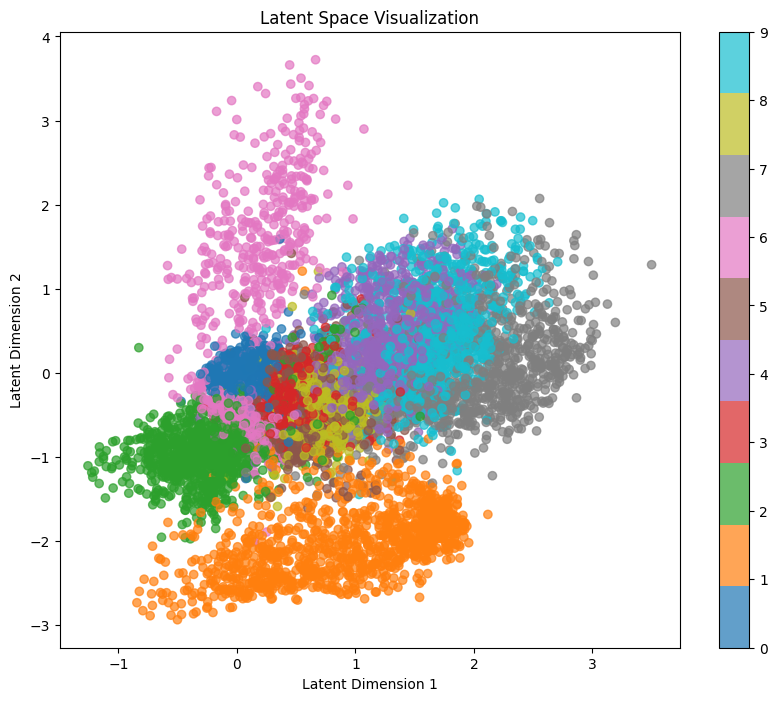

In [18]:
visualize_latens(test_loader, model)